<a href="https://colab.research.google.com/github/singularity014/BERT_Intent_Classification/blob/master/Intent_classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Classification

Prolem statement :
 -  Given a setence, predict the type of intent.
 - The data contains various user queries   categorized into seven intents.



# Data & Settings

Here are the intents:

- SearchCreativeWork (e.g. Find me the I, Robot television show)
- GetWeather (e.g. Is it windy in Boston, MA right now?)
- BookRestaurant (e.g. I want to book a highly rated restaurant for me and my boyfriend tomorrow night)
- PlayMusic (e.g. Play the last track from Beyoncé off Spotify)
- AddToPlaylist (e.g. Add Diamonds to my roadtrip playlist)
- RateBook (e.g. Give 6 stars to Of Mice and Men)
- SearchScreeningEvent (e.g. Check the showtimes for Wonder Woman in Paris)

In [15]:
# Downloading dataset
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 16.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 16.1MB/s]


## Setting up Environment

In [1]:
!nvidia-smi  # checking gpu 

Wed Jul 22 10:15:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null

In [3]:
!pip install --upgrade grpcio >> /dev/null 

In [4]:
!pip install tqdm  >> /dev/null # progress bar

In [5]:
!pip install bert-for-tf2 >> /dev/null # needed for bert tf2 version

In [6]:
!pip install sentencepiece >> /dev/null # Needed for Tensformer based models

## importing packages

In [12]:
from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

In [11]:
#BERT imports 
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [14]:
# plot and seed settings 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data operations

In [21]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")
valid.shape

(700, 2)

In [17]:
# Merging Training and Validation Data
# Because We will use Keras to define % of Val split
train = train.append(valid).reset_index(drop=True)

In [22]:
train.shape # about 700 data-points got merged

(13084, 2)

In [23]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


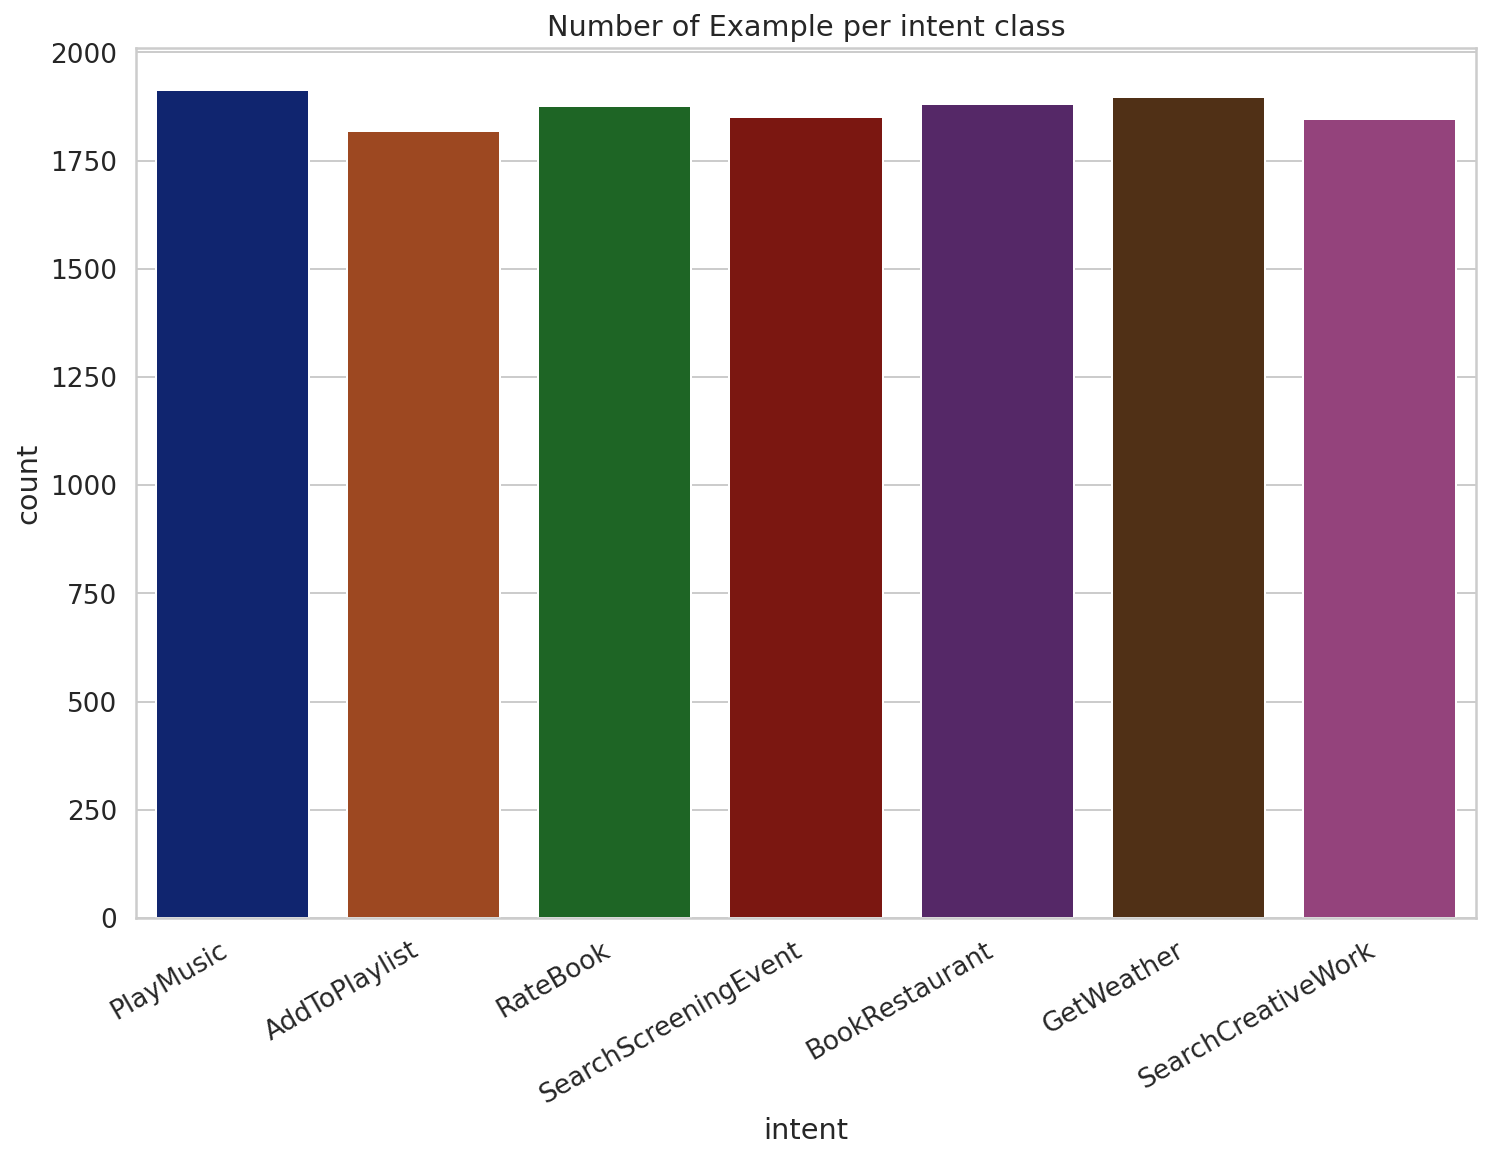

In [28]:
chart = sns.countplot(train.intent, palette="dark")
plt.title("Number of Example per intent class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');